<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

In [0]:
!pip install PyDrive

     |████████████████████████████████| 993kB 38.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# 10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J = train.csv
download = drive.CreateFile({'id': '10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J'})
download.GetContentFile('train.csv')

In [0]:
download = drive.CreateFile({'id': '10wykyV2NxcQSxDN4MRiunabPkUlBAFGo'})
download.GetContentFile('intermediate_features.csv')

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [0]:
!pip install distance

     |████████████████████████████████| 184kB 42.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [0]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

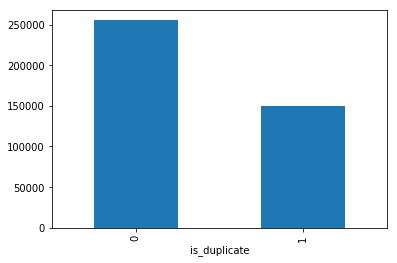

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



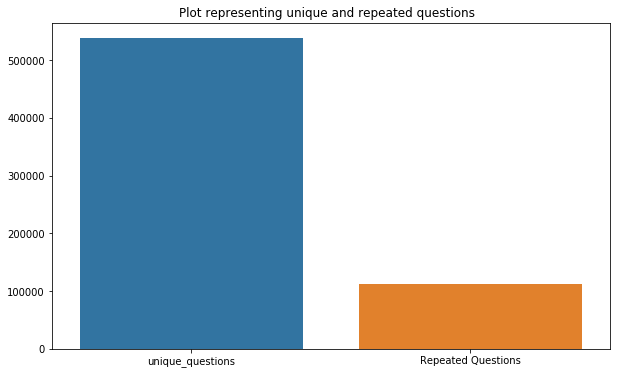

In [0]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



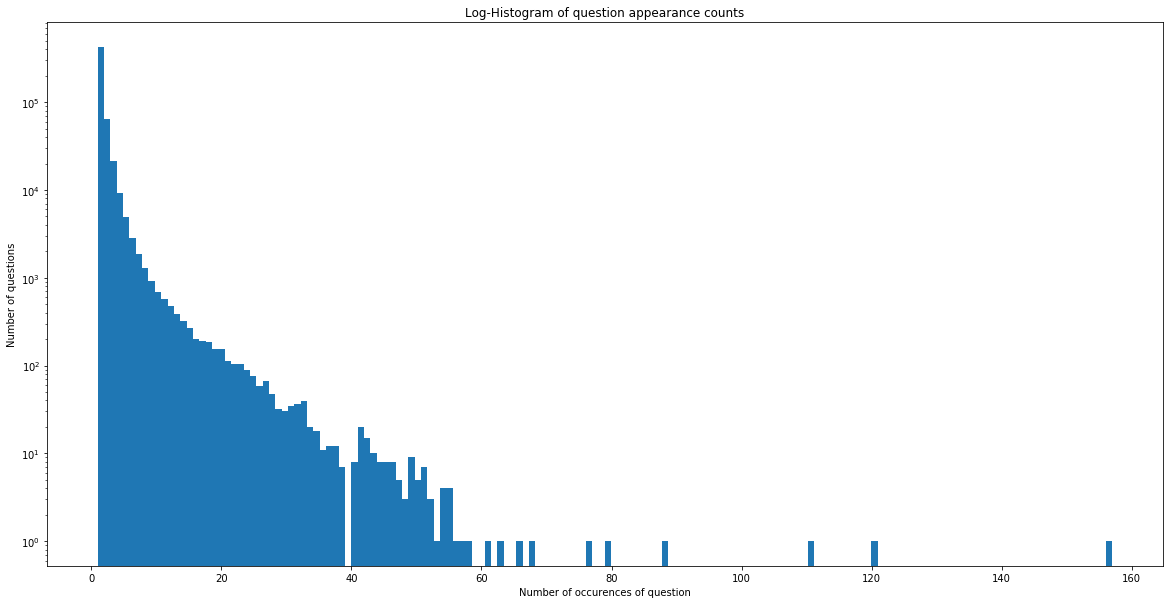

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## Some more Exploratory data analysis:

### Number of characters in questions

No handles with labels found to put in legend.


mean- 59.82 
std- 31.96 
max- 1169.00


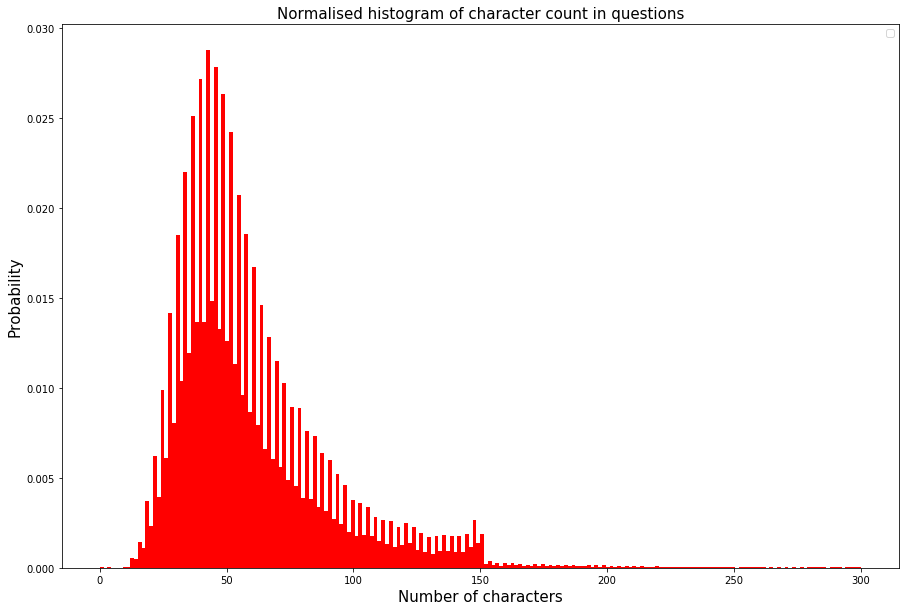

In [0]:
# Character count in questions
%matplotlib inline
train_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 300], color='red', normed=True)
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean- {:.2f} \nstd- {:.2f} \nmax- {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max()))

From the above histogram we can see that most of the questions have around 20 to 150 character. After that the probablity of getting questions with character count more than 150 drops drastically. This can be because most of the users want to keep the question title specific and to the point. 

The mean character count is around 60 and the max character a question has is astonishingly 1169 characters. 

Now as we have checked out the character count for questions, we can also take a look at how many words on average are there in the questions. 

### Number of words in questions

No handles with labels found to put in legend.


mean- 11.06 
std- 5.89 
max- 237.00


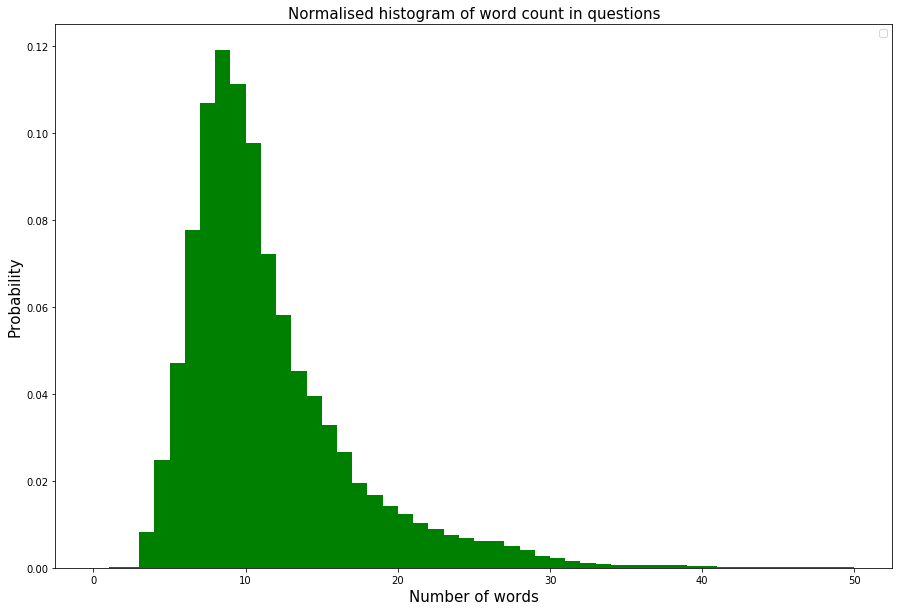

In [0]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color='green', normed=True)
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean- {:.2f} \nstd- {:.2f} \nmax- {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max()))

We can see a very similar distribution for word counts where most of the questions have a word count of 10, with very few questions having a word count above 30. 

The maximum number of words any question has in 237.

<h3> 3.2.5 Checking for NULL values </h3>

In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


- There are two rows with null values in question2 

In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

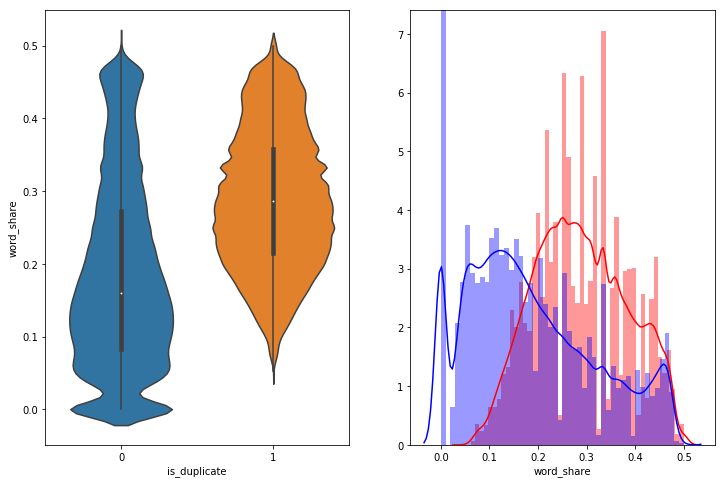

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

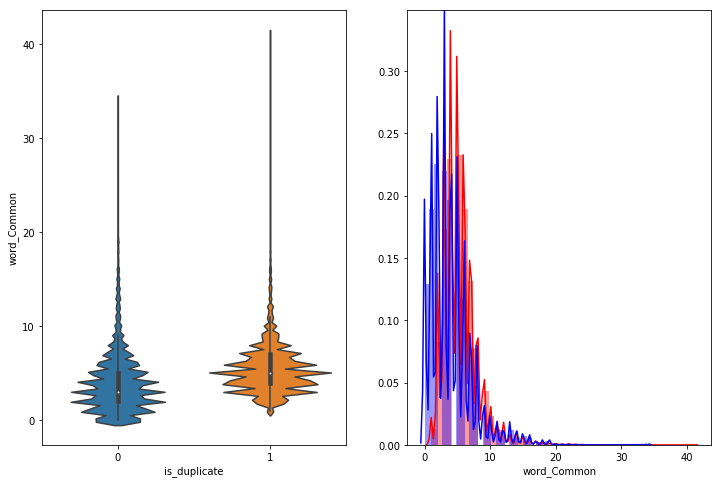

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### 1.2.1 : EDA: Advanced Feature Extraction.


In [0]:
!pip install fuzzywuzzy

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [0]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


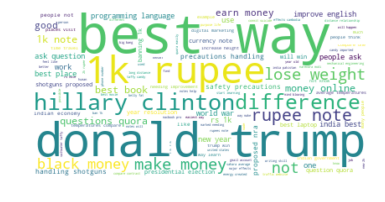

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


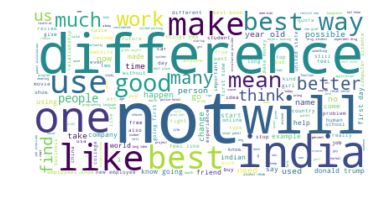

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

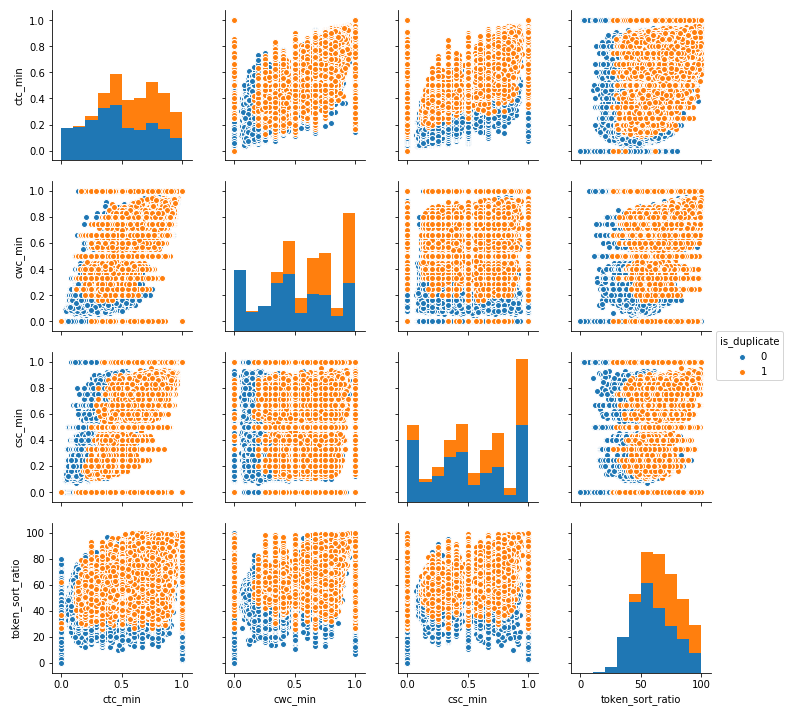

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

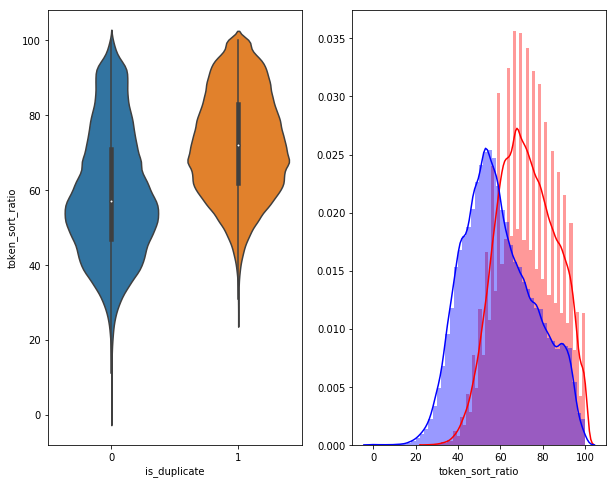

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

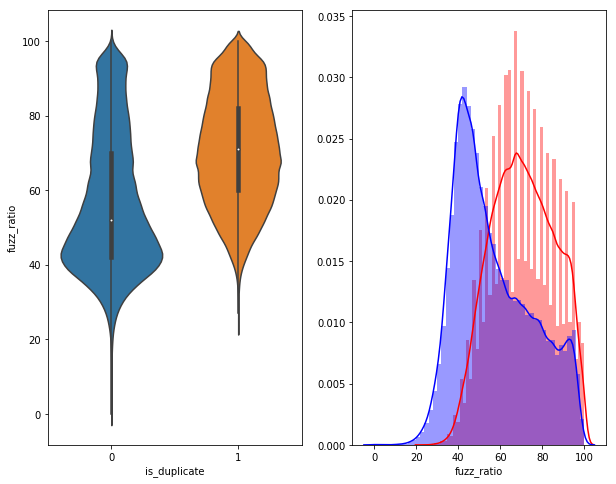

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.912s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.433s
[t-SNE] Iteration 50: error = 80.9244080, gradient norm = 0.0428133 (50 iterations in 13.099s)
[t-SNE] Iteration 100: error = 70.3858795, gradient norm = 0.0100968 (50 iterations in 9.067s)
[t-SNE] Iteration 150: error = 68.6138382, gradient norm = 0.0058392 (50 iterations in 9.602s)
[t-SNE] Iteration 200: error = 67.7700119, gradient norm = 0.0036596 (50 iterations in 9.121s)
[t-SNE] Iteration 250: error = 67.2725067, gradient norm = 0.003496

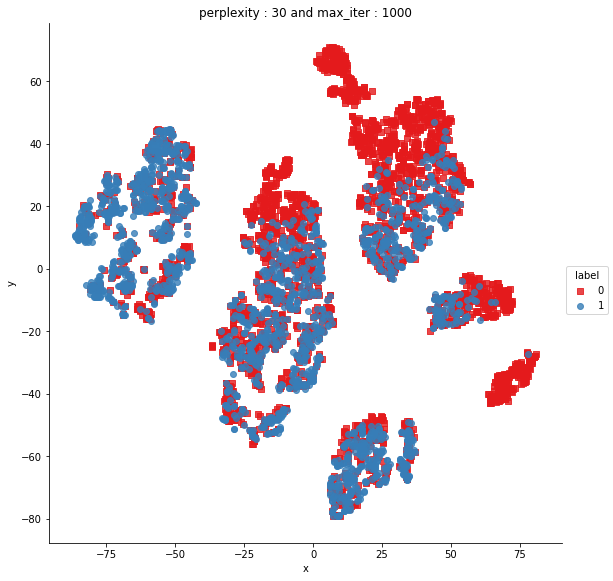

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.935s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.363s
[t-SNE] Iteration 50: error = 77.7944183, gradient norm = 0.1014017 (50 iterations in 34.931s)
[t-SNE] Iteration 100: error = 69.2682266, gradient norm = 0.0248657 (50 iterations in 15.147s)
[t-SNE] Iteration 150: error = 67.7877655, gradient norm = 0.0150941 (50 iterations in 13.761s)
[t-SNE] Iteration 200: error = 67.1991119, gradient norm = 0.0126559 (50 iterations in 13.425s)
[t-SNE] Iteration 250: error = 66.8560715, gradient norm = 0.007

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## Merging datasets to create a single dataset

Currently we have three datasets:
* `df` which have the raw train dataset
* `df_ppro` which contains the preprocessed dataset with basic features
* `df_nlp` with advanced features. 

Now we will merge the three datasets to create a single dataset, so that we can split it into train and test and convert question texts into vectors.

In [0]:
df = pd.read_csv("train.csv")
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))


if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','is_duplicate'],axis=1)
# df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
# df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [0]:
df1.head(1)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [0]:
df2.head(1)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0


In [0]:
df3.head(1)

,id,question1,question2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...


In [0]:
df1.merge(df2, on='id', how='left').shape

(404290, 28)

In [0]:
# storing the features to csv file
if not os.path.isfile('intermediate_features.csv'):
    df1  = df1.merge(df2, on='id',how='left')
    result  = df1.merge(df3, on='id',how='left')

In [0]:
result.head(1)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2
0,0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...


In [0]:
result.to_csv('intermediate_features.csv')

<h2> 4.3 Random train test split( 70:30) </h2>

In [0]:
y_true = result['is_duplicate']
data = result.drop(['is_duplicate'], axis=1)

In [0]:
data = data[0:100000]
y_true = y_true[0:100000]

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

### Converting questions (in TRAIN dataset) **to** tfidf_w2v using GLOVE pretrained model


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [0]:
from tqdm import tqdm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


100%|██████████| 70000/70000 [15:03<00:00, 77.51it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|██████████| 70000/70000 [15:37<00:00, 74.65it/s]


In [0]:
X_train.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2,q1_feats_m,q2_feats_m
70994,70994,0.333322,0.333322,0.749981,0.749981,0.571420,0.571420,0.0,1.0,0.0,7.0,88,71,81,76,0.314286,2,4,37,34,7,6,4.0,13.0,0.307692,6,2,How is the President of USA selected?,How is the U.S. President elected?,"[-37.98700523376465, 21.69734688103199, 68.970...","[-48.579386949539185, -11.177583903074265, 9.7..."
31728,31728,0.499992,0.374995,0.166664,0.111110,0.285712,0.199999,0.0,0.0,6.0,17.0,54,46,41,42,0.138462,1,1,63,89,13,19,3.0,28.0,0.107143,2,0,Can you get cat scratch fever if the cat didn'...,I've been scratched by a stray cat. It was a m...,"[43.14177078008652, 53.6145058600232, 12.31461...","[-101.96159034967422, -1.4183112382888794, 40...."


### Converting questions (in TEST dataset) to tfidf_w2v using GLOVE pretrained model

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_test['question1']) + list(X_test['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)


100%|██████████| 30000/30000 [06:33<00:00, 76.16it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|██████████| 30000/30000 [06:30<00:00, 76.83it/s]


In [0]:
X_test.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2,q1_feats_m,q2_feats_m
16823,16823,0.499988,0.399992,0.000000,0.000000,0.333328,0.249997,0.0,0.0,2.0,7.0,54,49,47,56,0.236842,2,1,46,37,8,6,1.0,14.0,0.071429,3,1,How did Luke Skywalker destroy the Death Star?,Can Star Destroyers destroy a planet?,"[-49.63350248336792, 94.57349079847336, 51.907...","[-3.066519796848297, 105.78574562072754, 5.573..."
78098,78098,0.749981,0.599988,0.749981,0.749981,0.749991,0.666659,0.0,0.0,1.0,8.5,83,66,34,38,0.239130,1,1,45,51,8,9,5.0,17.0,0.294118,2,0,What is the reality of Bhopal SIMI encounter?,Is the encounter of SIMI terrorists in Bhopal ...,"[-35.61477720737457, 70.23551306128502, 58.886...","[-20.272456288337708, 79.1100224852562, 41.821..."


## Merging the tfidf-w2v vectors as columns into the dataset

In [0]:
data_train = X_train
data_test = X_test

In [0]:
train_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index=X_train.index)
train_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index=X_train.index)

# Merging
train_q1['id']=data_train['id']
train_q2['id']=data_train['id']
df1  = train_q1.merge(train_q2, on='id',how='left')
data_train  = df1.merge(data_train, on='id',how='left')

In [0]:
data_train = data_train.drop(['id','question1', 'question2', 'q1_feats_m', 'q2_feats_m'], axis=1)
print("Number of features in train dataset: ", data_train.shape[1])

Number of features in train dataset:  794


In [0]:
data_train.to_csv("final_features_train.csv")

In [0]:
test_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index=X_test.index)
test_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index=X_test.index)

# Merging
if not os.path.isfile('final_features_test.csv'):
    test_q1['id']=data_test['id']
    test_q2['id']=data_test['id']
    df1  = test_q1.merge(test_q1, on='id',how='left')
    data_test  = df1.merge(data_test, on='id',how='left')
    data_test = data_test.drop(['id','question1', 'question2', 'q1_feats_m', 'q2_feats_m'], axis=1)
    print("Number of features in test dataset: ", data_test.shape[1])
    data_test.to_csv('final_features_test.csv')

Number of features in test dataset:  794


In [0]:
print("Number of features in nlp dataframe :", data_test.shape[1])
print("Number of features in preprocessed dataframe :", data_test.shape[1])
print("Number of features in question1 w2v  dataframe :", data_test.shape[1])
print("Number of features in question2 w2v  dataframe :", data_test.shape[1])
print("Number of features in final dataframe  :", data_test.shape[1]\
      +data_test.shape[1]+test_q1.shape[1]+test_q2.shape[1])

Number of features in nlp dataframe : 794
Number of features in preprocessed dataframe : 794
Number of features in question1 w2v  dataframe : 794
Number of features in question2 w2v  dataframe : 794
Number of features in final dataframe  : 2358


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from CSV file</h2>

In [0]:
data = pd.read_csv("final_features.csv")

In [0]:
data.head(1)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645


In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [0]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689
5,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,...,10.240244,10.188453,18.522278,-19.722884,-8.420450,9.489836,-7.418802,18.077984,16.476179,-2.602082


In [0]:
data_test.shape

(30000, 794)

<h2> 4.2 Converting strings to numerics </h2>

In [0]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model

# For train dataset
cols = list(data_train.columns)
for i in cols:
    data_train[i] = data_train[i].apply(pd.to_numeric)
    print(i)

0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136_x
137_x
138_x
139_x
140_x
141_x
142_x
143_x
144_x
145_x
146_x
147_x
148_x
149_x
150_x
151_x
152_x
153_x
154_x
155_x
156_x
157_x
158_x
159_x
160_x
161_x
162_x
163_x
164_x
165_x
166_x
167_x
168_x
169_x
170_x
171_x
172_x
173_x
174_x
175_x
176_x
177_x
178_x
179_x
180_x
181_x
182_x
183_x
184_x


In [0]:
# For test dataset
cols = list(data_test.columns)
for i in cols:
    data_test[i] = data_test[i].apply(pd.to_numeric)
    print(i)

0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136_x
137_x
138_x
139_x
140_x
141_x
142_x
143_x
144_x
145_x
146_x
147_x
148_x
149_x
150_x
151_x
152_x
153_x
154_x
155_x
156_x
157_x
158_x
159_x
160_x
161_x
162_x
163_x
164_x
165_x
166_x
167_x
168_x
169_x
170_x
171_x
172_x
173_x
174_x
175_x
176_x
177_x
178_x
179_x
180_x
181_x
182_x
183_x
184_x


In [0]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_train = list(map(int, y_train.values))
y_test = list(map(int, y_test.values))

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # sns.set()
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
   # sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    # sns.set()
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    # sns.set()
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8886412182138697


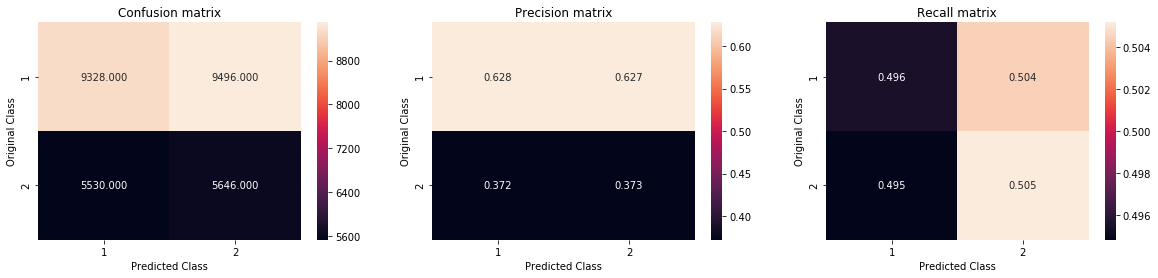

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [0]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

trans = StandardScaler()
data_train2 = trans.fit_transform(data_train)
data_test2 = trans.transform(data_test)

For values of alpha =  1e-05 The log loss is: 0.4460708592434588
For values of alpha =  0.0001 The log loss is: 0.40856045036066657
For values of alpha =  0.001 The log loss is: 0.40401389305528396
For values of alpha =  0.01 The log loss is: 0.412078233396203
For values of alpha =  0.1 The log loss is: 0.4504707859411557
For values of alpha =  1 The log loss is: 0.503545806002606
For values of alpha =  10 The log loss is: 0.5808620192273638
For values of alpha =  100 The log loss is: 0.6144395941691743
For values of alpha =  1000 The log loss is: 0.6186516467769855
For values of alpha =  10000 The log loss is: 0.6190844516297623


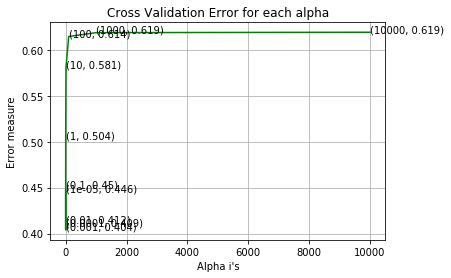

For values of best alpha =  0.001 The train log loss is: 0.39637635429035756
For values of best alpha =  0.001 The test log loss is: 0.40401389305528396
Total number of data points : 30000


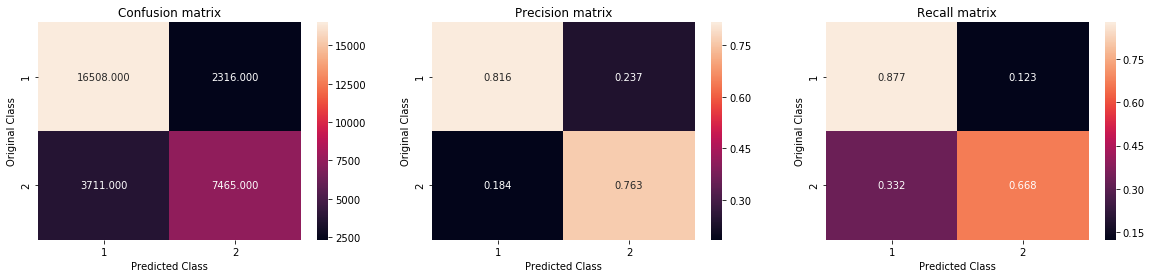

In [0]:
alpha = [10 ** x for x in range(-5, 5)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight='balanced')
    clf.fit(data_train2, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(data_train2, y_train)
    predict_y = sig_clf.predict_proba(data_test2)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, class_weight='balanced')
clf.fit(data_train2, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(data_train2, y_train)

predict_y = sig_clf.predict_proba(data_train2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(data_test2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4468456927302758
For values of alpha =  0.0001 The log loss is: 0.41561940123540686
For values of alpha =  0.001 The log loss is: 0.414269748220093
For values of alpha =  0.01 The log loss is: 0.40924294890644025
For values of alpha =  0.1 The log loss is: 0.4392599965629605
For values of alpha =  1 The log loss is: 0.4895856606840605
For values of alpha =  10 The log loss is: 0.5688926237782901
For values of alpha =  100 The log loss is: 0.6183176625075117
For values of alpha =  1000 The log loss is: 0.6191330460129488
For values of alpha =  10000 The log loss is: 0.6191330460101353


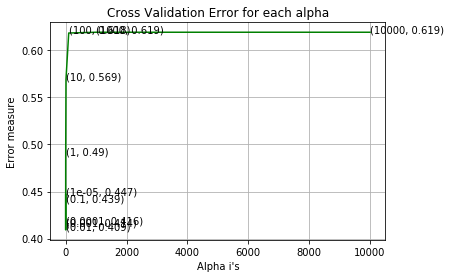

For values of best alpha =  0.01 The train log loss is: 0.402181855290563
For values of best alpha =  0.01 The test log loss is: 0.40924294890644025
Total number of data points : 30000


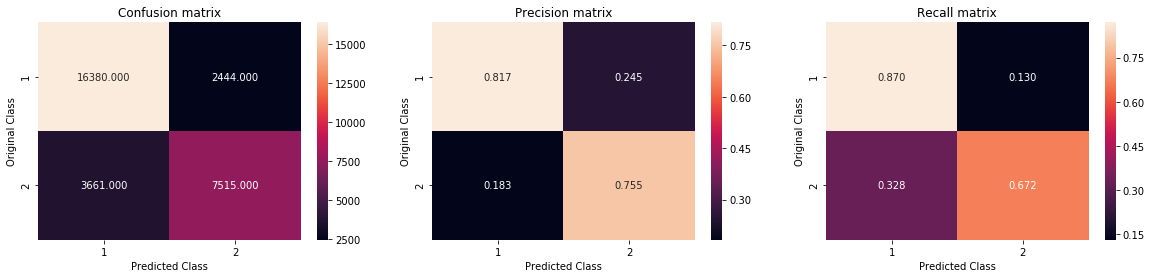

In [0]:
alpha = [10 ** x for x in range(-5, 5)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
    clf.fit(data_train2, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(data_train2, y_train)
    predict_y = sig_clf.predict_proba(data_test2)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
clf.fit(data_train2, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(data_train2, y_train)

predict_y = sig_clf.predict_proba(data_train2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(data_test2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

#### Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [0]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

clf = xgb.XGBClassifier()

param_grid = {
        'max_depth': [2, 4, 6, 8],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]
}


rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=5,\
                            verbose=2, n_jobs=1,cv=2,\
                            scoring='neg_log_loss', random_state=42)

rs_clf.fit(data_train, y_train)
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] max_depth=2, learning_rate=0.1 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=2, learning_rate=0.1, total= 2.2min
[CV] max_depth=2, learning_rate=0.1 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] ................... max_depth=2, learning_rate=0.1, total= 2.0min
[CV] max_depth=2, learning_rate=0 ....................................
[CV] ..................... max_depth=2, learning_rate=0, total= 2.1min
[CV] max_depth=2, learning_rate=0 ....................................
[CV] ..................... max_depth=2, learning_rate=0, total= 2.1min
[CV] max_depth=2, learning_rate=0.001 ................................
[CV] ................. max_depth=2, learning_rate=0.001, total= 2.1min
[CV] max_depth=2, learning_rate=0.001 ................................
[CV] ................. max_depth=2, learning_rate=0.001, total= 2.1min
[CV] max_depth=6, learning_rate=0 ....................................
[CV] ..................... max_depth=6, learning_rate=0, total= 5.6min
[CV] max_depth=6, learning_rate=0 ....................................
[CV] ..................... max_depth=6, learning_rate=0, total= 5.6min
[CV] max_depth=8, learning_rate=0.1 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 39.3min finished


Best score: -0.3393184314388341
Best params: 
learning_rate: 0.1
max_depth: 8


#### Applying the best parameters into our xgboost model to find out the final score

In [0]:
clf_optimal = rs_clf.best_estimator_

In [0]:
clf_optimal.fit(data_train, y_train)
predict_y = clf_optimal.predict_proba(data_test)

In [0]:
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

The test log loss is: 0.33468697752636507


From the above code snippet we can see that the test log loss is: 0.337. Now, we will see the confusion matrix.

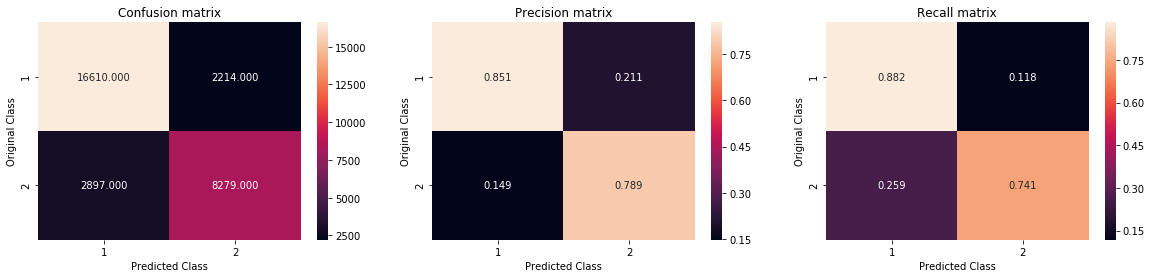

In [0]:
predicted_y =np.array(predict_y[:,1:2]>0.5,dtype=int)
plot_confusion_matrix(y_test, predicted_y)

## 1. Trying out Logistic regression, Linear SVM with simple TF-IDF vector

In [0]:
X_train = X_train.drop(['id', 'q1_feats_m', 'q2_feats_m'], axis=1)
X_test = X_test.drop(['id', 'q1_feats_m', 'q2_feats_m'], axis=1)

In [0]:
data_train = X_train
data_test = X_test

#### Converting question1 and question2 to TFIDF vectors

In [0]:
# Converting question 1 to tfidf vector

tfidf_vect1 = TfidfVectorizer(min_df=1)
q1_train = tfidf_vect1.fit_transform(data_train['question1'])
q1_test = tfidf_vect1.transform(data_test['question1'])

print("The shape of question1 vector:", q1_train.shape[1])

The shape of question1 vector: 30810


In [0]:
# Converting question 2 to tfidf vector

tfidf_vect2 = TfidfVectorizer(min_df=1)
q2_train = tfidf_vect2.fit_transform(data_train['question2'])
q2_test = tfidf_vect2.transform(data_test['question2'])

print("The shape of question1 vector:", q2_train.shape[1])

The shape of question1 vector: 28813


#### Concatenating all the data frames into one dataframe

In [0]:
# Droping the question1 and question2 column as we have the TFIDF vectors
X_train2 = data_train.drop(['question1', 'question2'], axis=1)
X_test2 = data_test.drop(['question1', 'question2'], axis=1)

In [0]:
# Horizontal stacking the features into one dataframe
from scipy.sparse import hstack

combined_train = hstack([q1_train, q2_train, X_train2])
combined_test = hstack([q1_test, q2_test, X_test2])

In [0]:
print("The shape of the combined train dataset: ", combined_train.shape[1])
print("The shape of the combined test dataset: ", combined_test.shape[1])

The shape of the combined train dataset:  59649
The shape of the combined test dataset:  59649


#### Standardize the data

In [0]:
trans = StandardScaler(with_mean=False)
combined_train = trans.fit_transform(combined_train)
combined_test = trans.transform(combined_test)

### Applying Logistic regression

For values of alpha =  1e-05 The log loss is: 0.40316178384518886
For values of alpha =  0.0001 The log loss is: 0.400705462572621
For values of alpha =  0.001 The log loss is: 0.41770729481618174
For values of alpha =  0.01 The log loss is: 0.43742073613790367
For values of alpha =  0.1 The log loss is: 0.45305074611864415
For values of alpha =  1 The log loss is: 0.48425881727672215
For values of alpha =  10 The log loss is: 0.5298864337776946
For values of alpha =  100 The log loss is: 0.5658435787352158
For values of alpha =  1000 The log loss is: 0.5770290211324792
For values of alpha =  10000 The log loss is: 0.5662237999625768


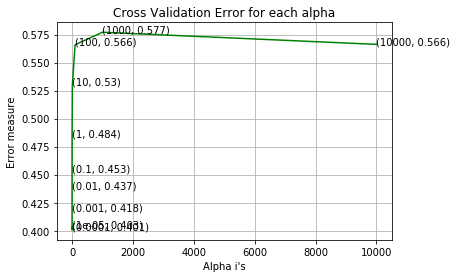

For values of best alpha =  0.0001 The train log loss is: 0.400151361260699
For values of best alpha =  0.0001 The test log loss is: 0.400705462572621
Total number of data points : 30000


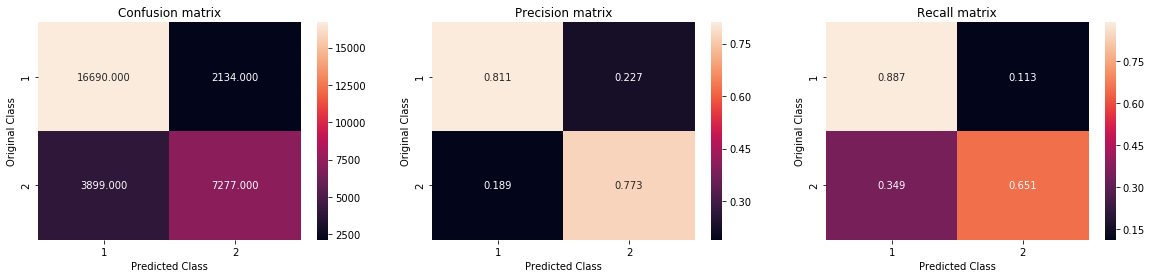

In [0]:
alpha = [10 ** x for x in range(-5, 5)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight='balanced')
    clf.fit(combined_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(combined_train, y_train)
    predict_y = sig_clf.predict_proba(combined_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, class_weight='balanced')
clf.fit(combined_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(combined_train, y_train)

predict_y = sig_clf.predict_proba(combined_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(combined_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Applying Linear SVM

For values of alpha =  1e-05 The log loss is: 0.4023924341811039
For values of alpha =  0.0001 The log loss is: 0.41291687419786494
For values of alpha =  0.001 The log loss is: 0.4230409192425223
For values of alpha =  0.01 The log loss is: 0.43387945047206977
For values of alpha =  0.1 The log loss is: 0.450185136824389
For values of alpha =  1 The log loss is: 0.4784453918388903
For values of alpha =  10 The log loss is: 0.5249337129874058
For values of alpha =  100 The log loss is: 0.5589874699870833
For values of alpha =  1000 The log loss is: 0.5703265802694719
For values of alpha =  10000 The log loss is: 0.5600005616240089


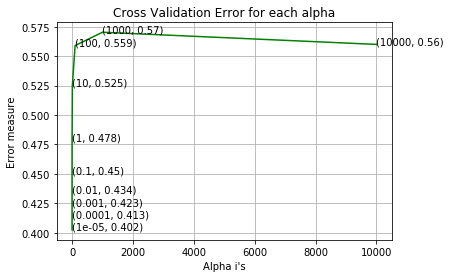

For values of best alpha =  1e-05 The train log loss is: 0.40279466457628144
For values of best alpha =  1e-05 The test log loss is: 0.4023924341811039
Total number of data points : 30000


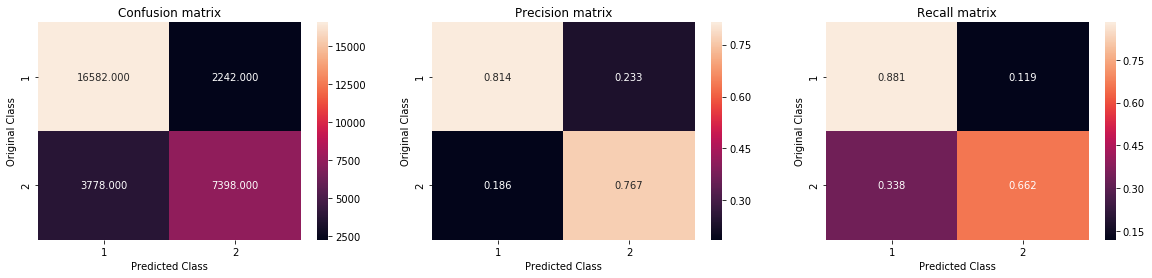

In [0]:
alpha = [10 ** x for x in range(-5, 5)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
    clf.fit(combined_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(combined_train, y_train)
    predict_y = sig_clf.predict_proba(combined_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(combined_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(combined_train, y_train)

predict_y = sig_clf.predict_proba(combined_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(combined_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusions:

| Model | Vectorizer  | Regularizer  | Hyperparameter | logloss |
|------:|-------------|--------------|--------|-----------|
| Logistic Regression | TFIDF-W2V | L2 | 0.001 (alpha) | 0.404
| Linear SVM | TFIDF-W2V | L2 |0.01  (alpha) | 0.409
| XGBoost | TFIDF-W2V | NA | learning_rate(0.1),max_depth(8) | 0.334
| Logistic Regression | TFIDF | L2 | 0.0001 (alpha) | 0.400
| Linear SVM | TFIDF | L2 |0.00001  (alpha) | 0.402


From the above table we can see that for the Quora question pair similarity problem, XGBoost performs much better (0.33 logloss) than simple logistic regression or Linear SVM.

## Steps followed to acheive 0.334 Logloss:

* In this case study our main objective was to find similarity between a pair of question asked in Quora, to determine if the questions are duplicate or not. Based on this Quora will either merge the questions or keep them separate.
* As a prediction, we did not want the models to directly declare a pair of questions as duplicate, but we needed the models to generate probablity values. And for that, as our performance metric we chose Logloss, as it works better with probability values. 
* In the EDA process, we first got some general statistics to get a feel for the overall data we will be dealing with in this case study. We also performed the following EDAs:
  * Number of occurrances of each question in the whole dataset
  * Number of character count for the qusetions (Added by me)
  * Number of word counts for the questions (Added by me)
  * Checking for null values: In this step we found out that there are 3 rows with null values, we removed the rows and went forward to feature engineering phase.
  
* After the initial analysis of the dataset, we created some basic features and tried finding out whether they hold some value in class prediction or not, by plotting the pdf and box plot for each feature. The basic featurs added in this step are:
   - ____freq_qid1____ = Frequency of qid1's
   - ____freq_qid2____ = Frequency of qid2's 
   - ____q1len____ = Length of q1
   - ____q2len____ = Length of q2
   - ____q1_n_words____ = Number of words in Question 1
   - ____q2_n_words____ = Number of words in Question 2
   - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
   - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
   - ____word_share____ = (word_common)/(word_Total)
   - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
   - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

* Then I preprocessed the question texts with basic html tag, stop word removal and stemming.
* After this some advance features were added which were more specific to the problem at hand (Finding similarity between a pair of texts), these features are: 
  - __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
  - __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
  - __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
  - __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
  - __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
  - __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))        
  - __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
  - __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])  
  - __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
  - __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
  - __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
  - __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
  - __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
  - __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
  - __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))
  
* After adding the advanced features, I merged three datasets (one with questions, one with basic features and the last one with advanced nlp features) into one dataset, and splitted the dataset into train and test datasets with 70:30 split.

* After vectorizing the dataset, I merged the datasets into a final train and final test dataset with 794 dimensions and applied Logistic regression, Linear SVM and XGBoost model on top of it. With this dataset, XGBoost performed the best among all three with 0.334 log loss. 
 
* Ofcourse, as XGBoost does not perform well with such high dimensional data, I applied Logistic regression and Linear SVM models on this data and got log loss of 0.406, 0.411 respectively. These values were significantly better than when I applied LR and Linear SVM on tfidf-w2v vectorized data which were 0.520 and 0.489 respectively.

 
 